# Faulted type 1 interference pattern
In this example we will model a faulted type 1 interference pattern. To build this model you need to have
* LoopStructural
* matplotlib
* lavavu

If you are using google colab or don't have them installed uncomment the following line

In [ ]:
#!pip install matplotlib lavavu-osmesa LoopStructural

In [1]:
import sys, os, subprocess
import matplotlib.pyplot as plt
# adjust some settings for matplotlib
from matplotlib import rcParams
import numpy as np
from LoopStructural.visualisation import LavaVuModelViewer, MapView
from LoopStructural.utils.helper import strike_dip_vector
from LoopStructural import GeologicalModel
import LoopStructural
import pandas as pd
# print rcParams
rcParams['font.size'] = 15
from LoopStructural import log_to_file
log_to_file('foldlog.loop')

In [2]:
df2 = pd.read_csv('https://raw.githubusercontent.com/lachlangrose/grose_et_al_2021_gmd_faults/main/faulted_fold_dataset.csv')#'faulted_fold_dataset.csv')

In [3]:
df2

,X,Y,Z,val,coord,feature_name,dip,strike,event
0,2698.000000,4920.000000,3968.0,0.0,0.0,fault,NaN,NaN,NaN
1,1.000000,2500.000000,4000.0,0.0,1.0,fault,NaN,NaN,NaN
2,7000.000000,2500.000000,4000.0,1.0,1.0,fault,NaN,NaN,NaN
3,1.000000,2500.000000,1000.0,0.0,2.0,fault,NaN,NaN,NaN
4,1.000000,2500.000000,4000.0,1.0,2.0,fault,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
508,7382.564523,5766.670682,4000.0,NaN,1.0,s1,90.0,-269.999654,1.0
509,858.123327,3147.781382,4000.0,NaN,1.0,s1,90.0,-269.999654,1.0
510,9404.028679,1598.228710,4000.0,NaN,1.0,s1,90.0,-89.999654,1.0
511,6225.717325,5299.308805,4000.0,NaN,1.0,s1,90.0,-89.999654,1.0


In [4]:
# df2 = pd.read_pickle("faults_paper_faulted_fold_example.pkl")
bb = np.zeros((2,3))
bb[1,:] =(10000.0, 7000.0, 5000.0)
rotation = [-74.35765075683594, -22.21700668334961, -3.0314273834228516]
images = []

## Create model including the fault

In [5]:
model = GeologicalModel(bb[0,:],bb[1,:])
model.set_model_data(df2)
fault = model.create_and_add_fault('fault',
                                   500,
                                   nelements=1e4,
                                   interpolatortype='FDI',
                                   buffer=0.31,
                                   solver='lu'
                                  )
fold_frame = model.create_and_add_fold_frame('s1',
                                nelements=1e4,
                                            regularisation=[1.,1.,.1],
                                            interpolatortype='FDI',
                                            solver='pyamg',
                                            damp=True,
                                            buffer=0.7)

model.update()
s0 = model.create_and_add_folded_foliation('s0',
                                           fold_frame=fold_frame,
                                      nelements=1e5,
                                          solver='lu',
                                           constrained=True,
                                          buffer=.5,
                                          )
model.update()


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

## Visualise model

In [6]:
view2 = LavaVuModelViewer(model)
view2.add_isosurface(s0,nslices=4)
view2.add_scalar_field(s0,cmap='tab20')
view2.add_data(s0)
view2.interactive()

## Create model without fault

In [7]:
model_no_fault = GeologicalModel(bb[0,:],bb[1,:])
model_no_fault.set_model_data(df2)
fold_frame2 = model_no_fault.create_and_add_fold_frame('s1',
                                nelements=1e4,
                                            regularisation=[1.,1.,.1],
                                            interpolatortype='FDI',
                                            solver='pyamg',
                                            damp=True,
                                            buffer=0.2)

s02 = model_no_fault.create_and_add_folded_foliation('s0',
                                           fold_frame=fold_frame2,
                                      nelements=1e5,
                                          solver='lu',
                                          buffer=0.5,
                                          damp=True)
model_no_fault.update()

  0%|          | 0/1 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/LoopStructural/modelling/fold/fold.py:49: RuntimeWarning: invalid value encountered in true_divide
  dgx[np.all(~np.isnan(dgx),axis=1),:] /= np.linalg.norm(dgx[np.all(~np.isnan(dgx),axis=1),:], axis=1)[:, None]
/opt/conda/lib/python3.7/site-packages/LoopStructural/modelling/fold/fold.py:50: RuntimeWarning: invalid value encountered in true_divide
  dgy[np.all(~np.isnan(dgy),axis=1)] /= np.linalg.norm(dgy[np.all(~np.isnan(dgy),axis=1)], axis=1)[:, None]
/opt/conda/lib/python3.7/site-packages/LoopStructural/modelling/fold/fold.py:87: RuntimeWarning: invalid value encountered in true_divide
  dgx[mask,:] /= np.linalg.norm(dgx[mask,:], axis=1)[:, None]


In [8]:
view2 = LavaVuModelViewer(model_no_fault)
view2.add_isosurface(s02,nslices=4)
view2.add_scalar_field(s02,cmap='tab20')
view2.add_data(s02)
view2.interactive()

### Add a stratigraphic column
Define the stratigraphy as 4 equally sized units and set the colours to a greyscale colourmap

In [9]:
step = (s0.max()-s0.min()) /4.
current = -np.inf
maxv = s0.min()+step*.5
stratigraphic_column = {'s0':{}}
i = 0
colour =  ["#595959","#7f7f7f","#a5a5a5","#cccccc","#f2f2f2"]
while current < s0.max():
    stratigraphic_column['s0']['unit{}'.format(i)] =  {'min':current,'max':maxv,'id':i,'colour':colour[i]}
    i+=1
    current = maxv
    maxv = current+step
    
stratigraphic_column['faults']  = {}

In [10]:
model.set_stratigraphic_column(stratigraphic_column)

### Plot model


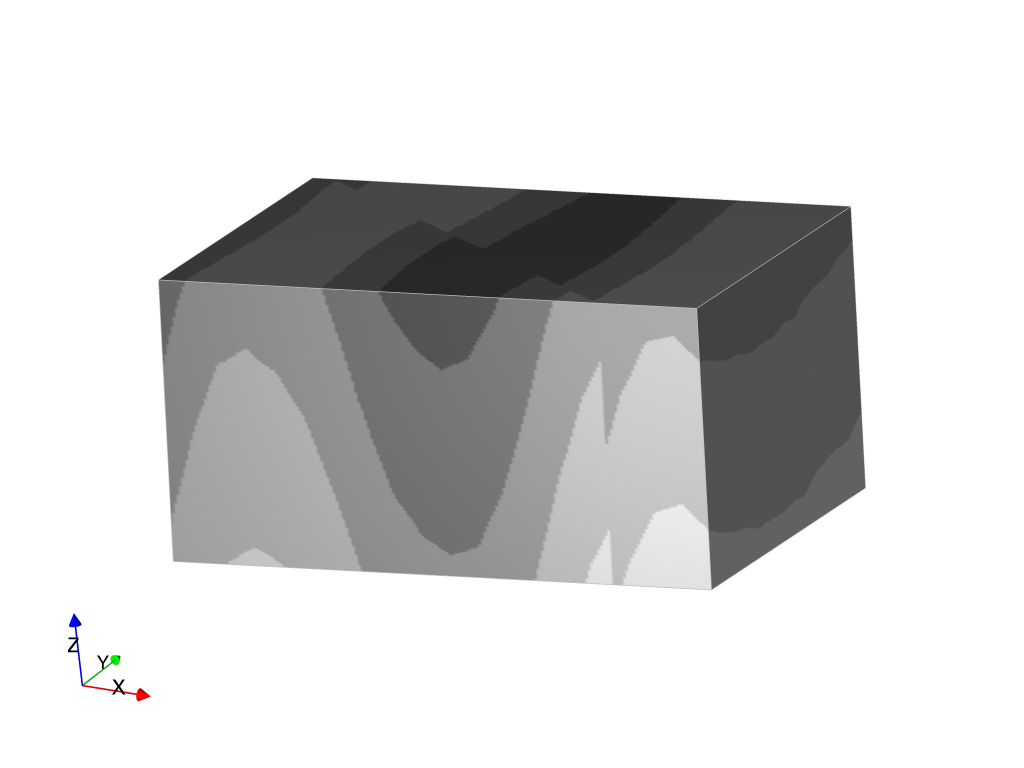

In [11]:
images = []
viewer = LavaVuModelViewer(model)
viewer.clear()
viewer.nsteps = np.array([200,200,200])

viewer.add_model()


viewer.rotation = rotation
# viewer.interactive()
images.append(viewer.image_array())
viewer.display()

### Plot model surfaces

  0%|          | 0/5 [00:00<?, ?it/s]

2021-04-17 08:30:55,876 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-17 08:30:55,876 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box
2021-04-17 08:30:55,876 ~ LoopStructural.visualisation.model_visualisation ~ WARNING    ~ Isovalue doesn't exist inside bounding box


Adding surfaces took 29.967028856277466 seconds



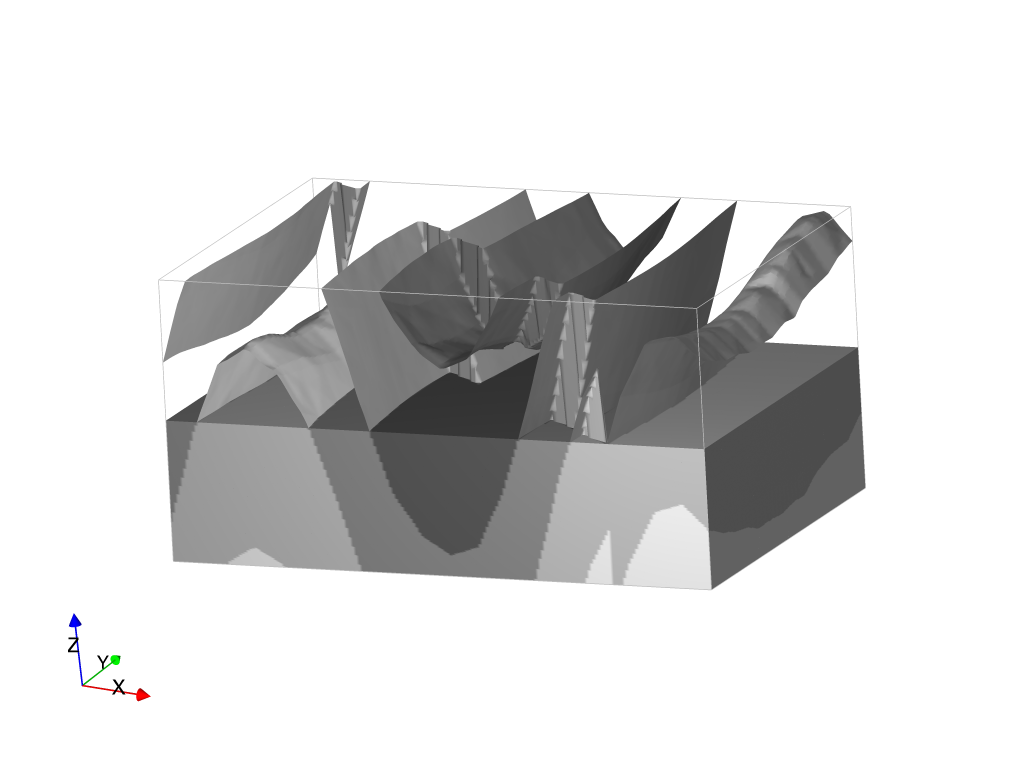

In [12]:
viewer.clear()
viewer.nsteps = np.array([100,100,100])
viewer.bounding_box[1,2] = 0.5

# viewer.add_data(s0)
# viewer.add_vector_field(s0,locations=s0.builder.get_gradient_constraints()[:,:3],colour='red')
viewer.add_model_surfaces(faults=False)
viewer.bounding_box[1,2] = 0.25
viewer.nsteps = np.array([200,200,200])

viewer.add_model()
viewer.rotation = rotation
images.append(viewer.image_array())
# viewer.interactive()
viewer.display()

## Plotting fold axial foliation field

In [ ]:
viewer.clear()
viewer.nsteps = np.array([50,50,50])
viewer.bounding_box[1,2] = 0.5
viewer.add_isosurface(fault,isovalue=0)
viewer.add_isosurface(fold_frame[0],nslices=5,paint_with=fold_frame[0],cmap='viridis')
viewer.bounding_box[1,2] = 0.25
viewer.nsteps = np.array([200,200,200])

viewer.add_scalar_field(fold_frame[0],cmap='viridis')
# viewer.add_isosurface(fold_frame[1],nslices=5,paint_with=fold_frame[1])
# viewer.add_vector_field(s0.fold.fold_axis,locations=model.regular_grid()[::20,:])
viewer.rotation = rotation
images.append(viewer.image_array())
viewer.display()

## Plotting fold axis direction field

In [14]:
viewer.clear()
viewer.nsteps = np.array([50,50,50])
viewer.bounding_box[1,2] = 0.5
viewer.add_isosurface(fault,isovalue=0)
viewer.add_isosurface(fold_frame[1],nslices=5,paint_with=fold_frame[1],cmap='viridis')
viewer.bounding_box[1,2] = 0.25
viewer.nsteps = np.array([200,200,200])
viewer.add_scalar_field(fold_frame[1],cmap='viridis')
# viewer.add_isosurface(fold_frame[1],nslices=5,paint_with=fold_frame[1])
# viewer.add_vector_field(s0.fold.fold_axis,locations=model.regular_grid()[::20,:])
viewer.rotation = rotation
images.append(viewer.image_array())

NameError: name 'viewer' is not defined

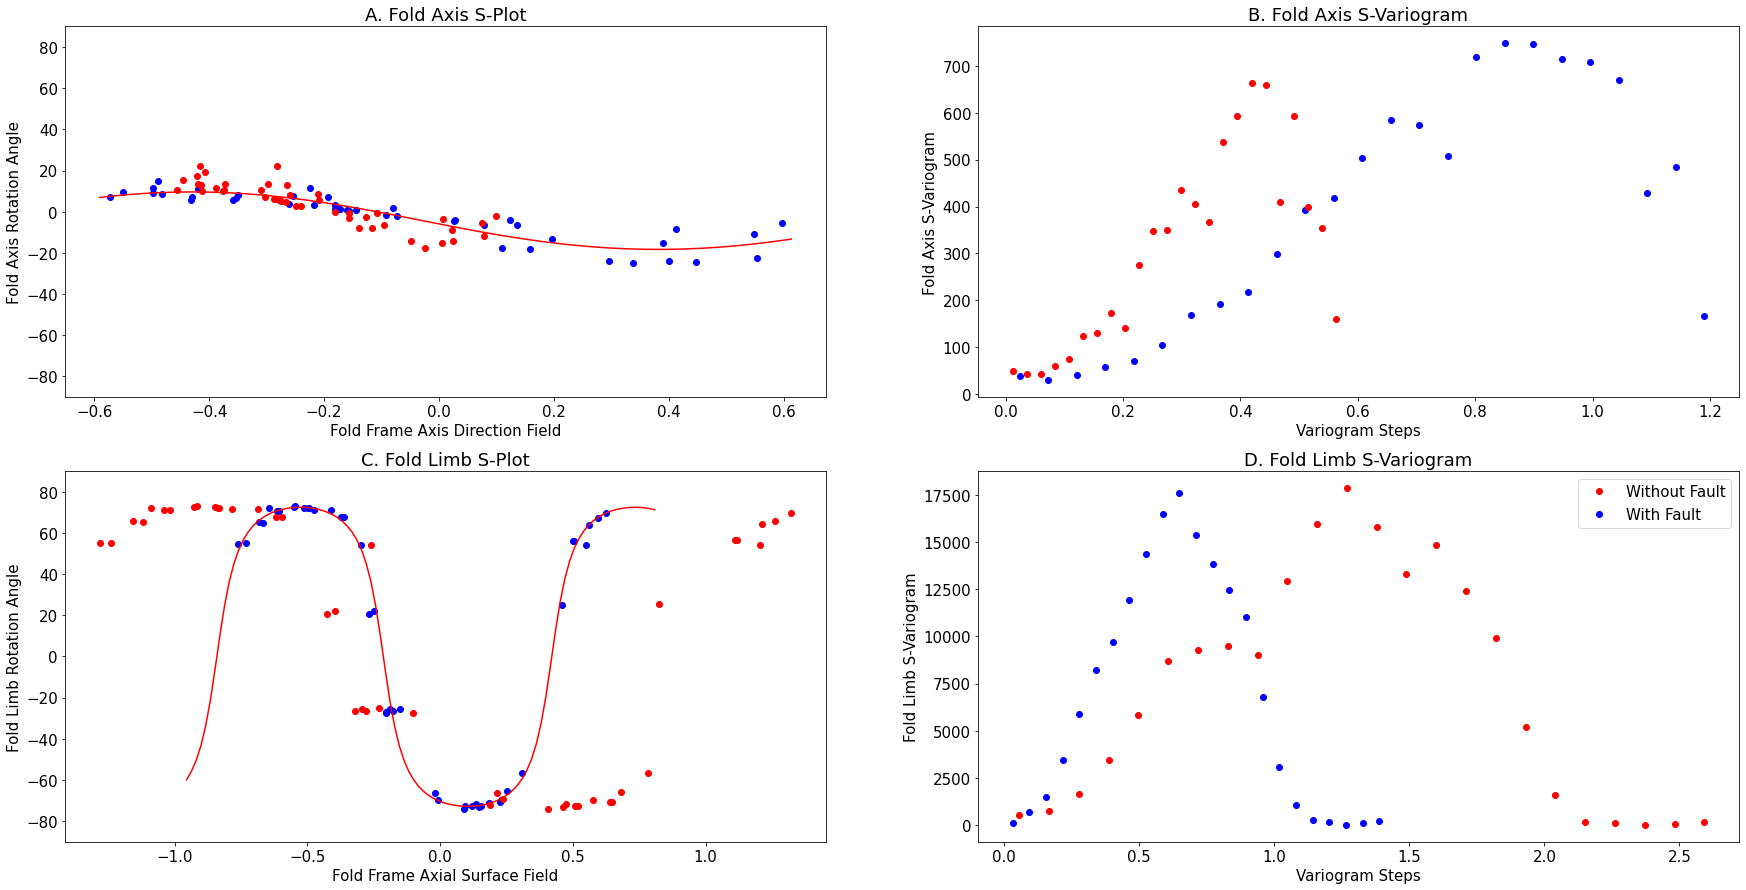

In [166]:
from LoopStructural.visualisation import RotationAnglePlotter
# link the model to the fold frame coordinates
# s0.fold.foldframe[0].set_model(model)
# s0.fold.foldframe[1].set_model(model)

rotation_angles = RotationAnglePlotter(s0)
rotation_angles.add_fold_limb_data()
rotation_angles.add_fold_limb_curve()
wi = rotation_angles.add_fold_axis_data(label='With fault')
rotation_angles.add_fold_axis_curve()
rotation_angles.add_limb_svariogram()
rotation_angles.add_axis_svariogram()

rotation_angles.feature = s02
wo =rotation_angles.add_fold_limb_data('ro',label='Without fault')
# rotation_angles.add_fold_limb_curve()
rotation_angles.add_fold_axis_data('ro')
# rotation_angles.add_fold_axis_curve()
rotation_angles.add_limb_svariogram('ro')
rotation_angles.add_axis_svariogram('ro')

rotation_angles.ax[0][0].set_title('A. Fold Axis S-Plot')
rotation_angles.ax[0][1].set_title('B. Fold Axis S-Variogram')
rotation_angles.ax[1][0].set_title('C. Fold Limb S-Plot')
rotation_angles.ax[1][1].set_title('D. Fold Limb S-Variogram')

rotation_angles.ax[1][1].set_xlabel('Variogram Steps')
rotation_angles.ax[1][1].set_ylabel('Fold Limb S-Variogram')
rotation_angles.ax[1][0].set_ylabel('Fold Limb Rotation Angle')
rotation_angles.ax[1][0].set_xlabel('Fold Frame Axial Surface Field')

rotation_angles.ax[0][1].set_xlabel('Variogram Steps')
rotation_angles.ax[0][1].set_ylabel('Fold Axis S-Variogram')
rotation_angles.ax[0][0].set_ylabel('Fold Axis Rotation Angle')
rotation_angles.ax[0][0].set_xlabel('Fold Frame Axis Direction Field')
rotation_angles.ax[1][1].legend(wo+wi,['Without Fault', 'With Fault'])

In [167]:
grad = s0.builder.get_gradient_constraints()
grad1 = s0.interpolator.get_gradient_constraints()
grad[:,:2]*=model.scale_factor
grad[:,:2]+=model.origin[:2]

grad1[:,:2]*=model.scale_factor
grad1[:,:2]+=model.origin[:2]


In [168]:
model.scale_factor

10000.0

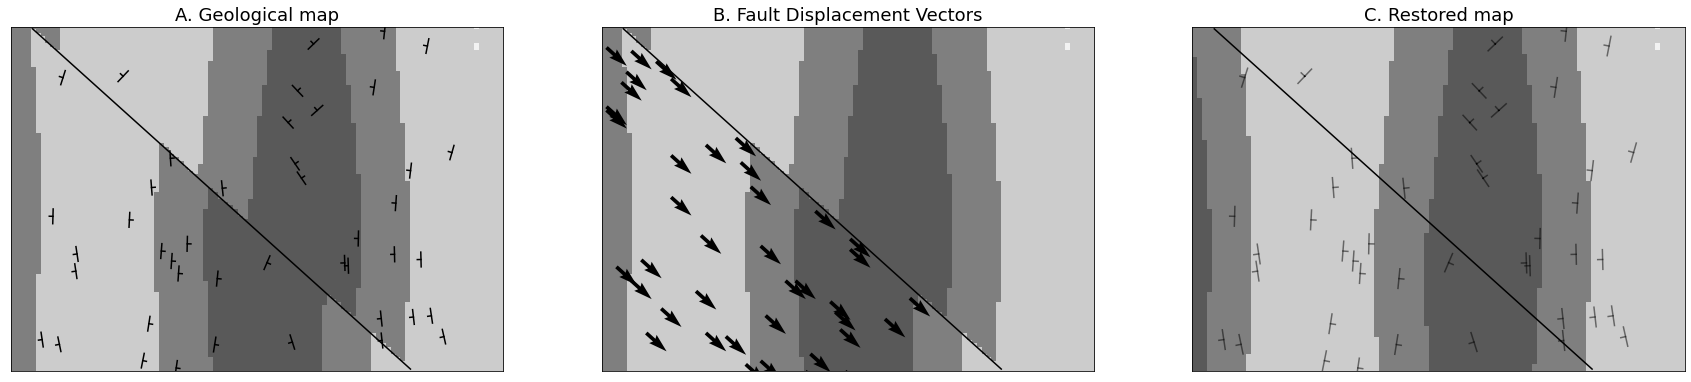

In [169]:
fig, ax = plt.subplots(1,3,figsize=(30,10))
mapview = MapView(model,ax=ax[0],nsteps=(10,10),)
mapview.nsteps = np.array([100,100])
# mapview.add_data(fold_frame[0],symb_scale=150,symb_colour='red',dip=False)
mapview.add_data(s0,symb_scale=150,symb_colour='black',dip=False)
# mapview.add_data(fault[0],symb_scale=150,symb_colour='green',dip=False,val=False)
plt.sca(ax[0])
mapview.add_model(z=model.maximum[2])
mapview.add_contour(fault[0],[0],colors='black')
xx = mapview.xx
# plt.xlim(model.bounding_box[0,0],model.bounding_box[1,0])
# plt.ylim(model.bounding_box[0,1],model.bounding_box[1,1])
# for d, xy, v in zip(dip,gcp[:,:2],gcp[:,3:6]):
# #     print(xy)
#     xy[0]+=v[1]*.01
#     xy[1]-=v[0]*.01

#     plt.annotate(d,xy,fontsize='xx-small')
# plt.scatter(gcp[:,0],gcp[:,1])
# mapview.ax.axis('/square')
# mapview.ax.axis('off')
ax[0].axes.xaxis.set_ticks([])#set_ticklabels([])
ax[0].axes.yaxis.set_ticks([])#set_ticklabels([])
ax[0].set_title('A. Geological map')

plt.sca(ax[1])
mapview2 = MapView(model,nsteps=[500,500],ax=ax[1])
mapview2.nsteps = np.array([100,100])
mapview2.add_model(z=model.maximum[2])
mapview2.add_contour(fault[0],[0],colors='black')
# mapview2.add_data(s0)
xx,yy = np.meshgrid(np.linspace(model.bounding_box[0,0],model.bounding_box[1,0],100),np.linspace(model.bounding_box[0,1],model.bounding_box[1,1],100))
# xx = mapview.xx
# yy = mapview.yy
zz = np.ones_like(xx)*model.bounding_box[1,2]
pts = np.vstack([xx.flatten(),yy.flatten(),zz.flatten()]).T
np.random.shuffle(pts)
pts = pts[::100,:]
vec = fault[1].evaluate_gradient(model.scale(pts,inplace=False))
mask = fault.evaluate(pts)

pts = model.rescale(pts,inplace=False)
ax[1].quiver(pts[mask,0],pts[mask,1],vec[mask,0],vec[mask,1])
ax[1].axes.xaxis.set_ticks([])#set_ticklabels([])
ax[1].axes.yaxis.set_ticks([])#set_ticklabels([])
ax[1].set_title('B. Fault Displacement Vectors')
# plt.quiver()
# mapview2.add_data(s0,scale=0.02,symb_colour='orange')
plt.sca(ax[2])


ax[2].set_title('C. Restored map')

mapview3 = MapView(model,nsteps=[500,500],ax=ax[2])
mapview3.nsteps = np.array([100,100])
mapview3.add_contour(fault[0],[0],colors='black')
s0.faults_enabled = False
mapview3.add_model(z=model.maximum[2])
s0.faults_enabled = True

# ax[2].plot([grad[:,0],grad1[:,0]],[grad[:,1],grad1[:,1]],'k--',alpha=0.2)
# plt.scatter(grad1[:,0],grad1[:,1],c='green')
symb_colour = 'black'
gradient_data = s0.interpolator.get_gradient_constraints()#np.hstack(ori_data)
# gradient_data[:,:3] = model.rescale(gradient_data[:,:3],inplace=False)
gradient_data[:, 3:5] /= np.linalg.norm(gradient_data[:, 3:5], axis=1)[:, None]
t = gradient_data[:, [4, 3]] * np.array([1, -1]).T
n = gradient_data[:, 3:5]
t *= 0.01
n *= 0.005
p1 = gradient_data[:, [0, 1]] - t
p2 = gradient_data[:, [0, 1]] + t
p1*=model.scale_factor
p1 += model.origin[:2]#model.rescale(p1,inplace=True)
p2*=model.scale_factor
p2 += model.origin[:2]#= model.rescale(p2,inplace=True)
# plt.scatter(val[:,0],val[:,1],c='black')
ax[2].plot([p1[:, 0], p2[:, 0]], [p1[:, 1], p2[:, 1]], symb_colour)
p1 = gradient_data[:, [0, 1]]
p2 = gradient_data[:, [0, 1]] + n
ax[2].plot([p1[:, 0], p2[:, 0]], [p1[:, 1], p2[:, 1]], symb_colour)
ax[2].axes.xaxis.set_ticks([])#set_ticklabels([])
ax[2].axes.yaxis.set_ticks([])
# ax[2].plot([grad[:,0],grad1[:,0]],[grad[:,1],grad1[:,/1]],'k--')
# plt.scatter(grad1[:,0],grad1[:,1],c='green')
symb_colour = 'black'
gradient_data = s0.builder.get_gradient_constraints()#np.hstack(ori_data)
# gradient_data[:,:3] = model.rescale(gradient_data[:,:3],inplace=False)

gradient_data[:, 3:5] /= np.linalg.norm(gradient_data[:, 3:5], axis=1)[:, None]
t = gradient_data[:, [4, 3]] * np.array([1, -1]).T
n = gradient_data[:, 3:5]
t *= 0.02
n *= 0.01
p1 = gradient_data[:, [0, 1]] - t
p2 = gradient_data[:, [0, 1]] + t
p1*=model.scale_factor
p1 += model.origin[:2]#model.rescale(p1,inplace=True)
p2*=model.scale_factor
p2 += model.origin[:2]#= model.rescale(p2,inplace=True)#= model.rescale(p2,inplace=True)
# plt.scatter(val[:,0],val[:,1],c='black')
lines = ax[2].plot([p1[:, 0], p2[:, 0]], [p1[:, 1], p2[:, 1]], symb_colour,alpha=0.5)
p1 = gradient_data[:, [0, 1]]
p2 = gradient_data[:, [0, 1]] + n
p1*=model.scale_factor
p1 += model.origin[:2]#model.rescale(p1,inplace=True)
p2*=model.scale_factor
p2 += model.origin[:2]#= model.rescale(p2,inplace=True)
lines = ax[2].plot([p1[:, 0], p2[:, 0]], [p1[:, 1], p2[:, 1]], symb_colour,alpha=0.5)
# fig.savefig('map.svg')

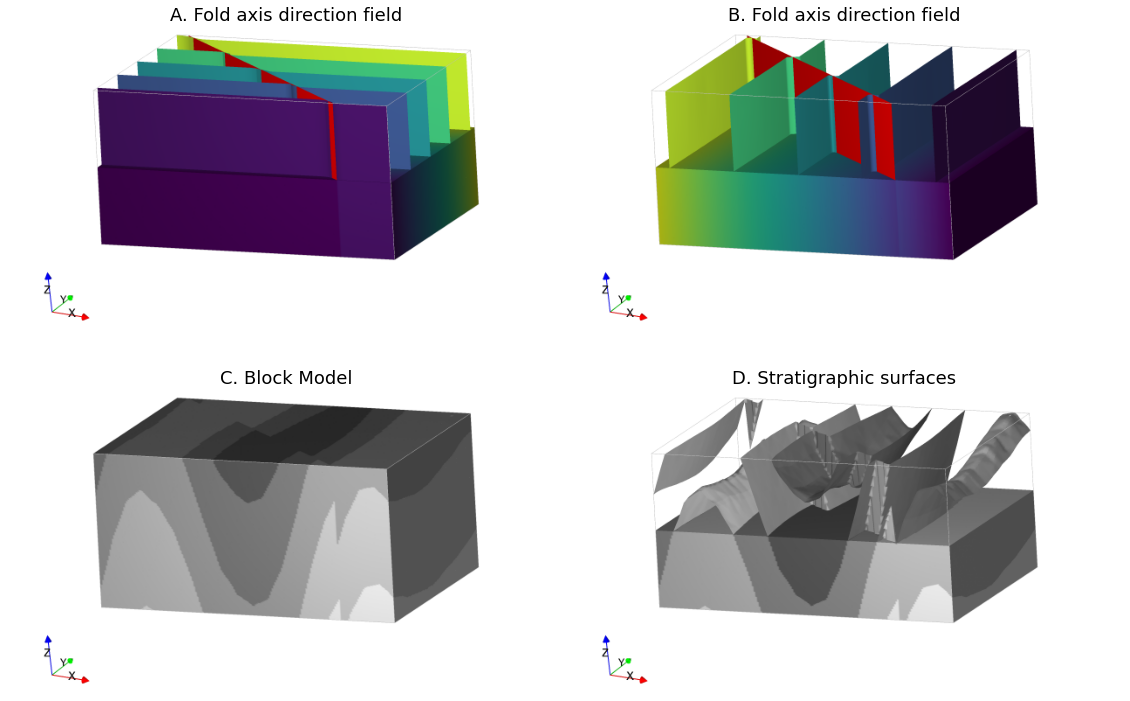

In [171]:
fig, ax = plt.subplots(2,2,figsize=(20,20))
ax[1][0].imshow(images[0][100:450,:])
ax[1][0].set_title('C. Block Model')
ax[1][1].imshow(images[1][100:450,:])
ax[1][1].set_title('D. Stratigraphic surfaces')

ax[0][0].imshow(images[3][100:450,:])
ax[0][0].set_title('A. Fold axis direction field')

ax[0][1].imshow(images[2][100:450,:])
ax[0][1].set_title('B. Fold axis direction field')
plt.subplots_adjust(wspace=0, hspace=-.5)

for i in range(2):
    for j in range(2):
        ax[i][j].axis('off')
# ax[0][0].axis('on')
# plt.tight_layout()

## 

In [13]:
view = LavaVuModelViewer(model)
view.add_model()
view.add_model_surfaces(faults=False)
view.add_data(model['s0'])
view.add_data(model['fault'][0])
view.add_data(model['s1'][0])
view.add_isosurface(model['fault'],value=0,colour='black')
view.add_vector_field(model['fault'][1],locations=model.regular_grid()[::100])
view.interactive()

AttributeError: 'NoneType' object has no attribute 'keys'

In [179]:
view.export_to_webgl('faulted_fold')